<a href="https://colab.research.google.com/github/Fr33zz/mw/blob/master/14%20check_payments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from datetime import date
import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
orders = gc.open_by_url('https://docs.google.com/spreadsheets/d/106Mk7_n9iXmCB-fuPFgpWsV1t7JtoAdPaePi5x8BFTM')

payments = gc.open_by_url('https://docs.google.com/spreadsheets/d/1OKkFUxN-a55K52Z6QO0wnZg9SB-_6d3VZ_BXDCYsGYc')

closed = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Gs7OkvQLNpt5IDTrsP5PBWbrSTO89zOPysbpbp7uzrQ')

sch_pay = gc.open_by_url('https://docs.google.com/spreadsheets/d/1AkH2q9AGbFuaXW3fUlrvvzcObFAr0vOkYdr2sNb4uLw')

opened = gc.open_by_url('https://docs.google.com/spreadsheets/d/1xUc4ayCcVNpkT1Bcx8_Hk84g02iM3U5GkxSSbZMMGAk')

charge = gc.open_by_url('https://docs.google.com/spreadsheets/d/1gOgXDjkxdjNaE-O-jprV77Tucdqm8uE-vg0NHDxP8xk')

def get_data(spreadsheet, list_number=0):
  ind = pd.DataFrame(spreadsheet.worksheets()[list_number].get_all_values())
  ind = ind.rename(columns=ind.iloc[0]).drop(index=0).reset_index().drop(columns='index')
  return ind

def get_titles(x, type_=1):
  '''type = {0:"list", 1:"df"}'''
  if type_==0:
    return [i.title for i in x.worksheets()]
  if type_==1:
    return pd.DataFrame([i.title for i in x.worksheets()])


def to_num(data, columns, print_=False):
  d = data.copy()
  for i in columns:
    try:       
      d[i] = d[i].map(lambda x: '.'.join(''.join(''.join(str(x).split('\xa0')).split(' ')).split(',')) if x!='' else np.nan).astype('float')
    except:
      if print_:
        print(i)
      else:
        None
  return d

#for i in dates:
#  d[i] = pd.to_datetime(d[i].replace({'':np.nan}), format='%d.%m.%Y')

In [ ]:
#ord = get_data(orders, 0)

#clos = pd.concat([get_data(closed, i) for i in [0,2,4,5,6,7]])

pay = get_data(payments, 0)
legal = get_data(payments, 3)

#opn = get_data(opened, 0)
#loan = get_data(opened, 0)
#claim = get_data(opened, 1)

In [ ]:
#loan  = to_num( loan,  loan.iloc[:,-17:].columns, True)
#claim = to_num(claim, claim.iloc[:,-15:].columns, True)

In [ ]:
legal.rename(columns={'Сумма платежа, руб.':'Сумма, руб.',
                      'Номер договора':'№',
                      'Дата поступления на р/с':'Дата списания платежа'}, inplace=True)

In [ ]:
p = pd.concat([pay[[ '№', 'Сумма, руб.', 'Дата списания платежа']], legal[['№', 'Сумма, руб.', 'Дата списания платежа']]])
p = p.reset_index().iloc[:,1:]
p = p.rename(columns={'Дата списания платежа':'date', 'Сумма, руб.':'sum', '№':'n'})
p['date'] = pd.to_datetime(p['date'].map(lambda x: np.nan if x=='нет данных' else x))
p['ddiff'] = p['date'].map(lambda x: (date.today() - x.date()).days if x==x else np.nan)

In [ ]:
d = get_data(charge, 1)

d1 = d[d['status']!=''][['№ договора', 'списанная сумма', 'Попытки']]\
    .rename(columns={'Попытки':'t',
                     'списанная сумма':'s',
                     '№ договора':'n'})
def make_d1(data):
  d = data.copy()
  
  d1 = d[d['status']!=''][['№ договора', 'списанная сумма', 'Попытки']]\
    .rename(columns={'Попытки':'t',
                     'списанная сумма':'s',
                     '№ договора':'n'})
  return d1

In [ ]:
def sum_pay(payments,  names,
            target_id, start_date='', end_date='', df=False):
  '''
  payments – dataframe of payments
  names = [ids_name, cash_name, date_name]
    ids_name – name of column with masked_id, like MW33333333
    cash_name – name of column with payment sum
    date_name – name of column with dates
  target_id – list of masked id we are interested in
  start_date – date from which we should count (YY-mm-dd)
  end_date – date to which we should count (YY-mm-dd)
  df – flag, True if we wanna get the dataframe instead of series
  '''

  ids_name  = names[0]
  cash_name = names[1]
  date_name = names[2]

  p = payments[payments[ids_name].isin(target_id)]
  p = to_num(p, [cash_name])

  try:
    if start_date!='' and end_date!='':
      p = p[p[date_name].isin(pd.date_range(start=start_date, end=end_date))]
  except:
    print('Error in dates')
    return -1
  p = p.groupby(ids_name).agg({cash_name:'sum'})
  return p if df==True else p[cash_name]

In [ ]:
sum_pay(p, p.columns, d1['n'].values, '2020-09-29', '2020-10-05').sum()

0.0

In [ ]:
p[p['ddiff']<4]

,n,sum,date,ddiff
32784,MW333352084,"4 104,19",2020-12-01,-8.0
32856,MW333352062,"2 052,00",2020-12-01,-8.0
32973,MW333350810,"5 750,00",2020-12-01,-8.0
32975,MW333352051,"3 542,00",2020-12-01,-8.0
33025,MW333365816,"3 494,00",2020-12-01,-8.0
...,...,...,...,...
48978,MW333358899,"380,00",2020-12-11,-18.0
48979,MW333367757,"863,15",2020-12-11,-18.0
48980,MW333330512,"1 707,35",2020-12-11,-18.0
48981,MW333353162,"5 633,21",2020-12-11,-18.0


In [ ]:
pay['Дата списания платежа'].str.split('.').map(lambda x: date(int(x[2]), int(x[1]), int(x[0])) if len(x)==3 else pd.NaT)

0        2015-07-09
1        2015-07-17
2        2015-07-23
3        2015-08-05
4        2015-08-06
            ...    
47068           NaT
47069           NaT
47070           NaT
47071    2020-11-22
47072           NaT
Name: Дата списания платежа, Length: 47073, dtype: object

In [ ]:
make_d1(d)['s'].unique

def try_num(x):
  if x=='':
    return 0
  try:
    if int(x):
      return int(x)
    else:
      return 0
  except:
    return 0

make_d1(d)['s'].map(lambda x: try_num(x))

0       0
1    3600
6     200
Name: s, dtype: int64

In [ ]:
#title_dict = get_titles(charge)[0].to_dict()

#for i in [3, 10, 11, 16, 17]:
#  title_dict.pop(i)

#for i in range(0,len(title_dict)-2):
#  d2 = make_d1(get_data(charge, i))
#  d2['s'] = d2['s'].map(lambda x: try_num(x))
#  print (title_dict[i], '  ',\
#         sum_pay(p, p.columns, d2['n'].values, title_dict[i], '2020-10-05').sum(),\
#         '  ', d2['s'].sum())

In [ ]:
import datetime

title_dict = get_titles(charge)[0]#.to_dict()
title_dict = title_dict[title_dict.str.split(pat='-').map(len)==3].reset_index()
title_dict[1] = title_dict[0].shift(1)

#title_dict.fillna(str(pd.Timestamp(datetime.datetime.now()).date()), inplace=True)
title_dict['today'] = pd.Timestamp(datetime.datetime.now()).date()

for i in [0,1]:
  title_dict[i] = pd.to_datetime(title_dict[i]).dt.date

title_dict = title_dict.rename(columns={0:'start', 1:'end'})

title_dict['days'] = (title_dict['end'] - title_dict['start']).dt.days
title_dict.iloc[0,-1] = 1.

title_dict

,index,start,end,today,days
0,0,2020-11-16,NaT,2020-11-23,1.0
1,1,2020-11-10,2020-11-16,2020-11-23,6.0
2,2,2020-11-03,2020-11-10,2020-11-23,7.0
3,3,2020-11-02,2020-11-03,2020-11-23,1.0
4,4,2020-10-30,2020-11-02,2020-11-23,3.0
5,5,2020-10-29,2020-10-30,2020-11-23,1.0
6,6,2020-10-28,2020-10-29,2020-11-23,1.0
7,7,2020-10-27,2020-10-28,2020-11-23,1.0
8,8,2020-10-26,2020-10-27,2020-11-23,1.0
9,9,2020-10-23,2020-10-26,2020-11-23,3.0


In [ ]:
d = get_data(charge, 0)
d['num'] = 0
cols = d.iloc[:,3:].columns

for i in range(1, title_dict.shape[0]):
  j = title_dict.iloc[i,0]
  d0 = get_data(charge, j)
  d0['num'] = j
  d = pd.concat([d, d0])
d = d[cols]

d  = to_num( d,  d.columns, True)

def try_to_num(x):
  try:
    return float(x)
  except:
    return np.nan

d['списанная сумма'] = d['списанная сумма'].map(try_to_num)
d['Попытки'] = d['Попытки'].map(try_to_num)

d = pd.merge(left = d, right = title_dict,\
             left_on='num', right_on='index', how='left')

№ договора
status
списанная сумма
Попытки
коммент
год-месяц
Дата


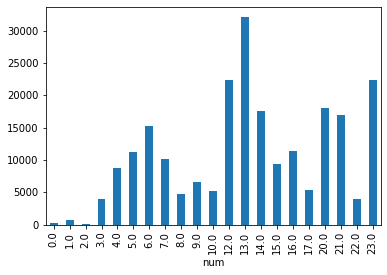

In [ ]:
d0 = d.groupby(['num']).\
      agg({'списанная сумма':'sum',
          'Попытки':'sum',
          'status':'count',
          'days':'min'})#.iloc[1:-1,:]


d0 = d0.rename(columns={'списанная сумма':'sum',
                        'Попытки':'tr',
                        'status':'ord'})

d0['sd']  = d0['sum'] / d0['days']
d0['td']  = d0['tr'] / d0['days']
d0['od']  = d0['ord'] / d0['days']

d0['av']  = d0['sd'] / d0['td']
d0['avt'] = d0['td']  / d0['od']
d0['avc'] = d0['sd'] / d0['od']

d0['sd'].plot.bar()

In [ ]:
d#[d['num']==10]

,№ договора,status,списанная сумма,Попытки,коммент,год-месяц,Срок просрочки (в днях),Общая сумма просроченной задолженности,Общая сумма текущей задолженности,Общая сумма задолженности,Полученная сумма заемщиком,Ежемесячный взнос,Сумма начисленных процентов,Дата,num,index,start,end,today,days
0,MW333389597,7,0.0,1.0,,2020-11,1.0,5553.00,0.0,5553.00,8217.0,5553.0,1307.84,2020-11-10,0.0,0,2020-11-16,NaT,2020-11-23,1.0
1,MW333389631,7,0.0,0.0,"оплачен, но открыт",2020-11,1.0,4302.00,0.0,4302.00,6365.0,4302.0,1013.08,2020-11-10,0.0,0,2020-11-16,NaT,2020-11-23,1.0
2,MW333389573,7,0.0,1.0,,2020-11,1.0,4265.00,0.0,4265.00,6311.0,4265.0,1004.48,2020-11-10,0.0,0,2020-11-16,NaT,2020-11-23,1.0
3,MW333389582,7,0.0,0.0,закрыт,2020-11,1.0,1618.00,0.0,1618.00,2395.0,1618.0,381.20,2020-11-10,0.0,0,2020-11-16,NaT,2020-11-23,1.0
4,MW333388251,7,0.0,0.0,закрыт,2020-11,4.0,4847.85,0.0,4847.85,7096.0,4796.0,1226.92,2020-11-10,0.0,0,2020-11-16,NaT,2020-11-23,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29509,MW333338881,1,0.0,0.0,23.09.2020,,799.0,824.00,0.0,824.00,5217.0,2849.0,481.00,2020-09-22,23.0,23,2020-09-22,2020-09-24,2020-11-23,2.0
29510,R877111,1,0.0,0.0,не корректная ссылка,,1581.0,1498.00,0.0,1498.00,1202.0,748.0,294.00,2020-09-22,23.0,23,2020-09-22,2020-09-24,2020-11-23,2.0
29511,R877098,1,0.0,0.0,не корректная ссылка,,1591.0,1498.00,0.0,1498.00,1202.0,748.0,294.00,2020-09-22,23.0,23,2020-09-22,2020-09-24,2020-11-23,2.0
29512,R876868,1,0.0,0.0,не корректная ссылка,,1692.0,1551.00,0.0,1551.00,1349.0,801.0,253.00,2020-09-22,23.0,23,2020-09-22,2020-09-24,2020-11-23,2.0


In [ ]:
#d
#get_data(charge, 0)

In [ ]:
d.to_csv('/content/drive/My Drive/analytics/14 callcenter_charge_strategy/data.csv')